# Installation

In [4]:
!pip install torch-scatter==latest+cpu -f https://pytorch-geometric.com/whl/torch-1.4.0.html

Looking in links: https://pytorch-geometric.com/whl/torch-1.4.0.html
     |████████████████████████████████| 532kB 1.7MB/s eta 0:00:01


In [5]:
!pip install torch-sparse==latest+cpu -f https://pytorch-geometric.com/whl/torch-1.4.0.html

Looking in links: https://pytorch-geometric.com/whl/torch-1.4.0.html
     |████████████████████████████████| 727kB 1.5MB/s eta 0:00:01


In [74]:
!pip install torch-cluster==latest+cpu -f https://pytorch-geometric.com/whl/torch-1.4.0.html

Looking in links: https://pytorch-geometric.com/whl/torch-1.4.0.html
     |████████████████████████████████| 466 kB 370 kB/s eta 0:00:01


In [6]:
!pip install torch-spline-conv==latest+cpu -f https://pytorch-geometric.com/whl/torch-1.4.0.html

Looking in links: https://pytorch-geometric.com/whl/torch-1.4.0.html
     |████████████████████████████████| 194kB 266kB/s eta 0:00:01


In [2]:
!pip install torch-geometric

     |████████████████████████████████| 1.6 MB 1.3 MB/s eta 0:00:01
     |████████████████████████████████| 67 kB 7.8 MB/s eta 0:00:01
     |████████████████████████████████| 12.4 MB 3.0 MB/s eta 0:00:01
     |████████████████████████████████| 4.3 MB 4.2 MB/s eta 0:00:01
     |████████████████████████████████| 3.3 MB 9.2 MB/s eta 0:00:01
     |████████████████████████████████| 60 kB 7.7 MB/s eta 0:00:01
  Using cached cycler-0.10.0-py2.py3-none-any.whl (6.5 kB)


# Example

## Dummy data

In [3]:
import torch
from torch_geometric.data import Data

In [5]:
#nodes in graph
x = torch.tensor([[2,1], [5,6], [3,7], [12,0]], dtype=torch.float)  #each node has two attributes
y = torch.tensor([0, 1, 0, 1], dtype=torch.float)                   #label of each node

#edges - graph connectivity
# in COO format
# first list: index of source node; second list: index of target nodes
# order is not important
edge_index = torch.tensor([[0, 1, 2, 0, 3],
                           [1, 0, 1, 3, 2]], dtype=torch.long)

#data
data = Data(x=x, y=y, edge_index=edge_index)

In [6]:
data

Data(edge_index=[2, 5], x=[4, 2], y=[4])

## display the graph

In [10]:
import networkx as nx
from torch_geometric.utils.convert import to_networkx
import matplotlib.pyplot as plt
%matplotlib inline

In [8]:
graph = to_networkx(data)

In [9]:
node_labels = data.y[list(graph.nodes)].numpy()

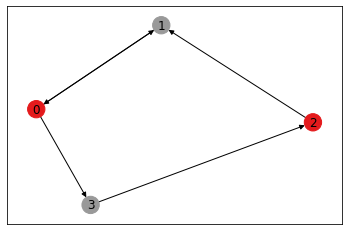

In [17]:
nx.draw_networkx(graph, node_color=node_labels, cmap=plt.get_cmap('Set1'))

## Get a benchmark dataset -> Node classification

Example data: CoRA dataset

The Cora dataset consists of Machine Learning papers. These papers are classified into one of the following seven classes:

		- Case_Based
		- Genetic_Algorithms
		- Neural_Networks
		- Probabilistic_Methods
		- Reinforcement_Learning
		- Rule_Learning
		- Theory

The papers were selected in a way such that in the final corpus every paper cites or is cited by atleast one other paper. There are 2708 papers in the whole corpus. 

After stemming and removing stopwords we were left with a vocabulary of size 1433 unique words. All words with document frequency less than 10 were removed.

In [22]:
from torch_geometric import datasets

In [23]:
dataset = datasets.Planetoid(root='/tmp/Cora', name='Cora')

In [24]:
len(dataset)  # a single, undirected citation graph

1

In [25]:
dataset.num_classes # number of classes

7

In [26]:
dataset.num_node_features # number of features for each node

1433

In [27]:
data = dataset[0]
data

Data(edge_index=[2, 10556], test_mask=[2708], train_mask=[2708], val_mask=[2708], x=[2708, 1433], y=[2708])

In [28]:
data.is_undirected()

True

In [29]:
data.train_mask.sum().item() #training data

140

In [30]:
data.val_mask.sum().item() #val data number

500

In [31]:
data.test_mask.sum().item() #test data number

1000

# GCN model

http://tkipf.github.io/graph-convolutional-networks/


## Define the model

In [14]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = GCNConv(dataset.num_node_features, 16)
        self.conv2 = GCNConv(16, dataset.num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)

        return F.log_softmax(x, dim=1)

In [33]:
def gnn_model_summary(model):
    
    model_params_list = list(model.named_parameters())
    print("----------------------------------------------------------------")
    line_new = "{:>20}  {:>25} {:>15}".format("Layer.Parameter", "Param Tensor Shape", "Param #")
    print(line_new)
    print("----------------------------------------------------------------")
    for elem in model_params_list:
        p_name = elem[0] 
        p_shape = list(elem[1].size())
        p_count = torch.tensor(elem[1].size()).prod().item()
        line_new = "{:>20}  {:>25} {:>15}".format(p_name, str(p_shape), str(p_count))
        print(line_new)
    print("----------------------------------------------------------------")
    total_params = sum([param.nelement() for param in model.parameters()])
    print("Total params:", total_params)
    num_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print("Trainable params:", num_trainable_params)
    print("Non-trainable params:", total_params - num_trainable_params)

In [34]:
model = Net().to(device)

gnn_model_summary(model)

----------------------------------------------------------------
     Layer.Parameter         Param Tensor Shape         Param #
----------------------------------------------------------------
        conv1.weight                 [1433, 16]           22928
          conv1.bias                       [16]              16
        conv2.weight                    [16, 7]             112
          conv2.bias                        [7]               7
----------------------------------------------------------------
Total params: 23063
Trainable params: 23063
Non-trainable params: 0


## Train

In [46]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net().to(device)
data = dataset[0].to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

model.train()
for epoch in range(200):
    optimizer.zero_grad()
    out = model(data)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    if epoch%20 == 0:
        print(f'Epoch {epoch} loss: {loss}')
    loss.backward()
    optimizer.step()

Epoch 0 loss: 1.9495536088943481
Epoch 20 loss: 0.2586601674556732
Epoch 40 loss: 0.05975053831934929
Epoch 60 loss: 0.05132346972823143
Epoch 80 loss: 0.04427019879221916
Epoch 100 loss: 0.04855520650744438
Epoch 120 loss: 0.02983223646879196
Epoch 140 loss: 0.03208761662244797
Epoch 160 loss: 0.0388658232986927
Epoch 180 loss: 0.03348282352089882


## Eval

In [47]:
model.eval()
_, pred = model(data).max(dim=1)
correct = float (pred[data.test_mask].eq(data.y[data.test_mask]).sum().item())
acc = correct / data.test_mask.sum().item()
print('Accuracy: {:.4f}'.format(acc))

Accuracy: 0.7880


# Graph classification model

all graph classification datasets from http://graphkernels.cs.tu-dortmund.de/ and their cleaned versions, the QM7 and QM9 dataset, and a handful of 3D mesh/point cloud datasets like FAUST, ModelNet10/40 and ShapeNet.

In [35]:
import os.path as osp

import torch
import torch.nn.functional as F
from torch_geometric.datasets import TUDataset
from torch_geometric.data import DataLoader
from torch_geometric.nn import GraphConv, TopKPooling
from torch_geometric.nn import global_mean_pool as gap, global_max_pool as gmp

In [36]:
dataset = TUDataset('/tmp/PROTEINS', name='PROTEINS')
dataset = dataset.shuffle()
n = len(dataset) // 10
test_dataset = dataset[:n]
train_dataset = dataset[n:]
test_loader = DataLoader(test_dataset, batch_size=60)
train_loader = DataLoader(train_dataset, batch_size=60)


In [37]:
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.conv1 = GraphConv(dataset.num_features, 128)
        self.pool1 = TopKPooling(128, ratio=0.8)
        self.conv2 = GraphConv(128, 128)
        self.pool2 = TopKPooling(128, ratio=0.8)
        self.conv3 = GraphConv(128, 128)
        self.pool3 = TopKPooling(128, ratio=0.8)

        self.lin1 = torch.nn.Linear(256, 128)
        self.lin2 = torch.nn.Linear(128, 64)
        self.lin3 = torch.nn.Linear(64, dataset.num_classes)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch

        x = F.relu(self.conv1(x, edge_index))
        x, edge_index, _, batch, _, _ = self.pool1(x, edge_index, None, batch)
        x1 = torch.cat([gmp(x, batch), gap(x, batch)], dim=1)

        x = F.relu(self.conv2(x, edge_index))
        x, edge_index, _, batch, _, _ = self.pool2(x, edge_index, None, batch)
        x2 = torch.cat([gmp(x, batch), gap(x, batch)], dim=1)

        x = F.relu(self.conv3(x, edge_index))
        x, edge_index, _, batch, _, _ = self.pool3(x, edge_index, None, batch)
        x3 = torch.cat([gmp(x, batch), gap(x, batch)], dim=1)

        x = x1 + x2 + x3

        x = F.relu(self.lin1(x))
        x = F.dropout(x, p=0.5, training=self.training)
        x = F.relu(self.lin2(x))
        x = F.log_softmax(self.lin3(x), dim=-1)

        return x


In [38]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net().to(device)
gnn_model_summary(model)

----------------------------------------------------------------
     Layer.Parameter         Param Tensor Shape         Param #
----------------------------------------------------------------
        conv1.weight                   [3, 128]             384
    conv1.lin.weight                   [128, 3]             384
      conv1.lin.bias                      [128]             128
        pool1.weight                   [1, 128]             128
        conv2.weight                 [128, 128]           16384
    conv2.lin.weight                 [128, 128]           16384
      conv2.lin.bias                      [128]             128
        pool2.weight                   [1, 128]             128
        conv3.weight                 [128, 128]           16384
    conv3.lin.weight                 [128, 128]           16384
      conv3.lin.bias                      [128]             128
        pool3.weight                   [1, 128]             128
         lin1.weight                 [

In [39]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)


def train(epoch):
    model.train()

    loss_all = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, data.y)
        loss.backward()
        loss_all += data.num_graphs * loss.item()
        optimizer.step()
    return loss_all / len(train_dataset)


def test(loader):
    model.eval()

    correct = 0
    for data in loader:
        data = data.to(device)
        pred = model(data).max(dim=1)[1]
        correct += pred.eq(data.y).sum().item()
    return correct / len(loader.dataset)


for epoch in range(1, 201):
    loss = train(epoch)
    train_acc = test(train_loader)
    test_acc = test(test_loader)
    print('Epoch: {:03d}, Loss: {:.5f}, Train Acc: {:.5f}, Test Acc: {:.5f}'.
          format(epoch, loss, train_acc, test_acc))


Epoch: 001, Loss: 0.63015, Train Acc: 0.69361, Test Acc: 0.72072
Epoch: 002, Loss: 0.58364, Train Acc: 0.72355, Test Acc: 0.74775
Epoch: 003, Loss: 0.56786, Train Acc: 0.72655, Test Acc: 0.75676
Epoch: 004, Loss: 0.56600, Train Acc: 0.72555, Test Acc: 0.73874
Epoch: 005, Loss: 0.56387, Train Acc: 0.73752, Test Acc: 0.77477
Epoch: 006, Loss: 0.54130, Train Acc: 0.74651, Test Acc: 0.77477
Epoch: 007, Loss: 0.52640, Train Acc: 0.74451, Test Acc: 0.78378
Epoch: 008, Loss: 0.53398, Train Acc: 0.75549, Test Acc: 0.76577
Epoch: 009, Loss: 0.53325, Train Acc: 0.75349, Test Acc: 0.74775
Epoch: 010, Loss: 0.52646, Train Acc: 0.75848, Test Acc: 0.76577
Epoch: 011, Loss: 0.52536, Train Acc: 0.75948, Test Acc: 0.75676
Epoch: 012, Loss: 0.52458, Train Acc: 0.76447, Test Acc: 0.75676
Epoch: 013, Loss: 0.51213, Train Acc: 0.76747, Test Acc: 0.74775
Epoch: 014, Loss: 0.51200, Train Acc: 0.77146, Test Acc: 0.72072
Epoch: 015, Loss: 0.51064, Train Acc: 0.77246, Test Acc: 0.72973
Epoch: 016, Loss: 0.51497

Epoch: 128, Loss: 0.17862, Train Acc: 0.95908, Test Acc: 0.69369
Epoch: 129, Loss: 0.17694, Train Acc: 0.94810, Test Acc: 0.69369
Epoch: 130, Loss: 0.15498, Train Acc: 0.93114, Test Acc: 0.72072
Epoch: 131, Loss: 0.21982, Train Acc: 0.91218, Test Acc: 0.68468
Epoch: 132, Loss: 0.21708, Train Acc: 0.94112, Test Acc: 0.66667
Epoch: 133, Loss: 0.17883, Train Acc: 0.96108, Test Acc: 0.68468
Epoch: 134, Loss: 0.18278, Train Acc: 0.94910, Test Acc: 0.65766
Epoch: 135, Loss: 0.18160, Train Acc: 0.95709, Test Acc: 0.68468
Epoch: 136, Loss: 0.19600, Train Acc: 0.94511, Test Acc: 0.69369
Epoch: 137, Loss: 0.19639, Train Acc: 0.93713, Test Acc: 0.72072
Epoch: 138, Loss: 0.18137, Train Acc: 0.95609, Test Acc: 0.70270
Epoch: 139, Loss: 0.19140, Train Acc: 0.91317, Test Acc: 0.67568
Epoch: 140, Loss: 0.24238, Train Acc: 0.93513, Test Acc: 0.71171
Epoch: 141, Loss: 0.21919, Train Acc: 0.94112, Test Acc: 0.73874
Epoch: 142, Loss: 0.16829, Train Acc: 0.96108, Test Acc: 0.70270
Epoch: 143, Loss: 0.13392

# Dynamic Edge Conv model

In [ ]:
from torch_geometric import datasets
dataset = datasets.TUDataset(root='/tmp/ENZYMES', name='ENZYMES')
dataset

In [2]:
len(dataset) #dataset include 600 graphs

600

In [3]:
dataset.num_classes

6

In [4]:
dataset.num_node_features

3

In [5]:
#check the number of nodes of each graph
print([len(g.x) for g in dataset])

[37, 23, 25, 24, 23, 24, 26, 88, 23, 32, 4, 14, 42, 41, 36, 55, 40, 38, 2, 35, 42, 41, 39, 42, 41, 40, 37, 23, 22, 34, 38, 38, 39, 8, 23, 42, 42, 100, 24, 24, 47, 45, 45, 45, 46, 44, 30, 32, 33, 9, 27, 39, 16, 18, 7, 18, 10, 21, 18, 10, 9, 39, 33, 29, 24, 25, 30, 38, 28, 28, 38, 40, 40, 42, 20, 19, 16, 17, 20, 18, 33, 23, 23, 35, 33, 39, 40, 38, 40, 38, 37, 36, 34, 34, 32, 18, 32, 34, 30, 5, 45, 42, 59, 32, 33, 17, 39, 38, 35, 16, 26, 51, 52, 25, 27, 42, 46, 96, 12, 22, 42, 14, 90, 14, 14, 32, 11, 26, 11, 14, 18, 16, 17, 32, 13, 3, 22, 16, 38, 13, 12, 14, 39, 19, 20, 39, 40, 39, 39, 29, 22, 11, 8, 13, 18, 12, 8, 40, 12, 22, 22, 18, 12, 17, 14, 22, 43, 42, 44, 24, 48, 25, 46, 48, 25, 48, 44, 42, 40, 38, 40, 41, 42, 40, 44, 24, 44, 20, 42, 27, 48, 31, 30, 46, 47, 50, 40, 55, 62, 34, 29, 25, 56, 57, 27, 22, 24, 23, 57, 24, 24, 23, 25, 23, 48, 27, 15, 44, 29, 21, 34, 30, 40, 54, 18, 36, 37, 34, 23, 32, 33, 29, 39, 34, 36, 21, 6, 22, 18, 18, 34, 32, 33, 28, 40, 42, 39, 28, 29, 30, 14, 32, 3

In [6]:
# split train/test

dataset = dataset.shuffle()
train_dataset = dataset[:540]
test_dataset = dataset[540:]

In [7]:
#mini-batches
from torch_geometric.data import DataLoader

In [8]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=6)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=6)

# Dynamic Edge Conv model

DGCNN

MLP

In [9]:
import torch
import torch.nn.functional as F
from torch.nn import Sequential as Seq, Dropout, Linear as Lin, ReLU, BatchNorm1d as BN
from torch_geometric.nn import DynamicEdgeConv, global_max_pool

In [10]:
def MLP(channels, batch_norm=True):
    return Seq(*[
        Seq(Lin(channels[i - 1], channels[i]), ReLU(), BN(channels[i]))
        for i in range(1, len(channels))
    ])

In [11]:
class Net(torch.nn.Module):
    def __init__(self, out_channels, k=20, aggr='max'):
        super().__init__()

        self.conv1 = DynamicEdgeConv(MLP([2 * 3, 64, 64, 64]), k, aggr)
        self.conv2 = DynamicEdgeConv(MLP([2 * 64, 128]), k, aggr)
        self.lin1 = MLP([128 + 64, 1024])

        self.mlp = Seq(
            MLP([1024, 512]), Dropout(0.5), MLP([512, 256]), Dropout(0.5),
            Lin(256, out_channels))

    def forward(self, data):
        pos, batch = data.pos, data.batch
        x1 = self.conv1(pos, batch)
        x2 = self.conv2(x1, batch)
        out = self.lin1(torch.cat([x1, x2], dim=1))
        out = global_max_pool(out, batch)
        out = self.mlp(out)
        return F.log_softmax(out, dim=1)

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net(train_dataset.num_classes, k=20).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)


def train():
    model.train()

    total_loss = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data)
        loss = F.nll_loss(out, data.y)
        loss.backward()
        total_loss += loss.item() * data.num_graphs
        optimizer.step()
    return total_loss / len(train_dataset)


def test(loader):
    model.eval()

    correct = 0
    for data in loader:
        data = data.to(device)
        with torch.no_grad():
            pred = model(data).max(dim=1)[1]
        correct += pred.eq(data.y).sum().item()
    return correct / len(loader.dataset)


for epoch in range(1, 201):
    loss = train()
    test_acc = test(test_loader)
    print('Epoch {:03d}, Loss: {:.4f}, Test: {:.4f}'.format(
        epoch, loss, test_acc))
    scheduler.step()

AttributeError: 'NoneType' object has no attribute 'dim'

# More examples

https://github.com/rusty1s/pytorch_geometric/tree/master/examples